## 1) Carga del dataset

Configura `DATA_PATH` con el nombre/ruta del archivo CSV descargado desde Kaggle.
Luego cargamos y hacemos una primera inspección.


In [2]:
# ====== Configuración de ruta ======
DATA_PATH = "kag_risk_factors_cervical_cancer.csv"  # <-- ajusta esto si tu archivo se llama diferente

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score,
                             RocCurveDisplay)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



# ====== Configuración de ruta ======
DATA_PATH = "kag_risk_factors_cervical_cancer.csv"  # <-- ajusta esto si tu archivo se llama diferente


df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
display(df_raw.head())
df_raw.info()


Shape: (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

## 2) Limpieza básica y tipado

Este dataset suele incluir:
- valores faltantes representados como `"?"` o strings vacíos,
- columnas booleanas (0/1) y numéricas,
- posibles mezclas de tipos.

Estrategia:
1. Reemplazar `"?"`/vacíos por `NaN`.
2. Convertir columnas a numérico cuando sea posible.
3. Crear una copia `df` lista para análisis.


In [3]:

df = df_raw.copy()

# Reemplazo robusto de símbolos de faltantes
df = df.replace(["?", " ? ", "NA", "N/A", "", " "], np.nan)

# Intentar convertir a numérico (si falla, se mantiene como objeto)
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c], errors="ignore")

# Si aún quedan objetos, intenta de nuevo forzando a numérico (coerce) cuando haya muchos valores numéricos
for c in df.columns:
    if df[c].dtype == "object":
        # Heurística: si 80% se puede convertir a numérico, convertir con coerce
        coerced = pd.to_numeric(df[c], errors="coerce")
        ratio_numeric = coerced.notna().mean()
        if ratio_numeric >= 0.80:
            df[c] = coerced

print("Tipos finales:")
display(df.dtypes.value_counts())
display(df.head())


Tipos finales:


C:\Users\guiss\AppData\Local\Temp\ipykernel_29608\779124273.py:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


float64    26
int64      10
Name: count, dtype: int64

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


## 3) Selección de variable objetivo (target)

In [4]:
TARGET = "Biopsy"
print("Target seleccionado:", TARGET)
display(df[TARGET].value_counts(dropna=False))

Target seleccionado: Biopsy


Biopsy
0    803
1     55
Name: count, dtype: int64

## 4) EDA / Calidad de datos: faltantes, duplicados y distribución del target

Duplicados: 23


,missing_ratio
STDs: Time since last diagnosis,0.917249
STDs: Time since first diagnosis,0.917249
IUD,0.136364
IUD (years),0.136364
Hormonal Contraceptives,0.125874
Hormonal Contraceptives (years),0.125874
STDs:pelvic inflammatory disease,0.122378
STDs:vulvo-perineal condylomatosis,0.122378
STDs:HPV,0.122378
STDs:Hepatitis B,0.122378


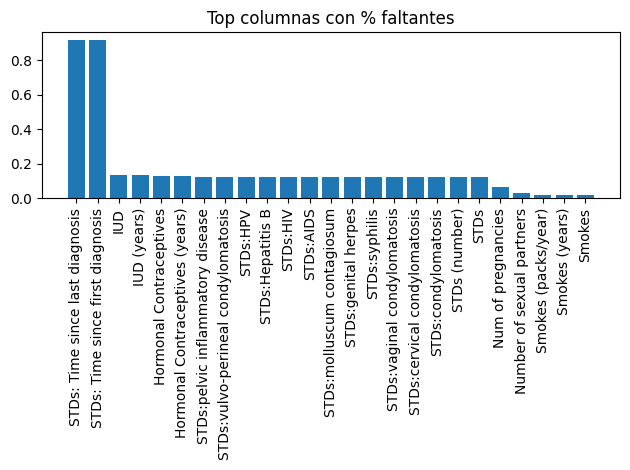

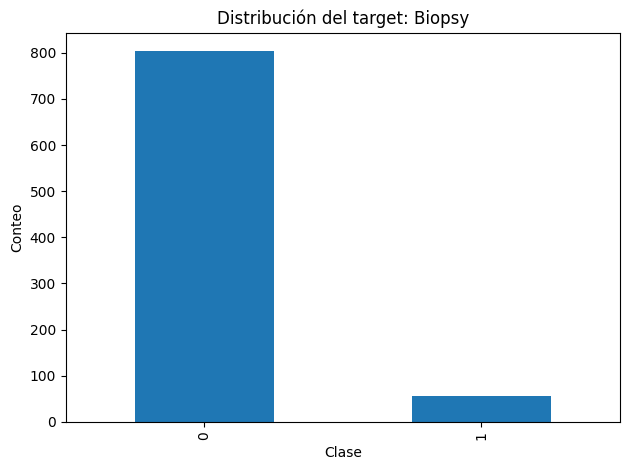

In [5]:
# Duplicados
dup = df.duplicated().sum()
print("Duplicados:", dup)

# Faltantes por columna (si quieres mostrar algo en el informe)
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio").head(15))

# Visual simple de missingness (top 25)
top = missing.head(25)
plt.figure()
plt.bar(range(len(top)), top.values)
plt.xticks(range(len(top)), top.index, rotation=90)
plt.title("Top columnas con % faltantes")
plt.tight_layout()
plt.show()

# Distribución del target
y = df[TARGET]
y.value_counts(dropna=False).plot(kind="bar")
plt.title(f"Distribución del target: {TARGET}")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()


### 4.1) Eliminación de variables por alto *missing ratio*

Las variables **`STDs: Time since last diagnosis`** y **`STDs: Time since first diagnosis`** presentan un **porcentaje de valores faltantes muy alto**, lo que reduce significativamente su utilidad analítica y puede introducir sesgos o inestabilidad en los modelos si se imputan de forma artificial.  
Por esta razón, y siguiendo buenas prácticas de preprocesamiento, se eliminan del análisis para mejorar la calidad y consistencia del conjunto de datos.


In [6]:
# Eliminar variables con alto porcentaje de valores faltantes (missing ratio)
cols_to_drop = [
    "STDs: Time since last diagnosis",
    "STDs: Time since first diagnosis"
]

# Drop seguro (no falla si alguna columna no existe)
df = df.drop(columns=cols_to_drop, errors="ignore")

# Verificación rápida
print("Columnas eliminadas (si existían):", cols_to_drop)
print("\nColumnas restantes:", df.shape[1])


Columnas eliminadas (si existían): ['STDs: Time since last diagnosis', 'STDs: Time since first diagnosis']

Columnas restantes: 34


## 5) EDA / Graficos
> Nota: muchas variables son discretas/booleanas, así que “normalidad” no siempre es aplicable. Aun así, verificaremos numéricas continuas y reportaremos resultados.


Numéricas (sin target): 33


,count,mean,std,min,25%,50%,75%,max
Age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
Number of sexual partners,832.0,2.527644,1.667760,1.0,2.0,2.0,3.0,28.0
First sexual intercourse,851.0,16.995300,2.803355,10.0,15.0,17.0,18.0,32.0
Num of pregnancies,802.0,2.275561,1.447414,0.0,1.0,2.0,3.0,11.0
Smokes,845.0,0.145562,0.352876,0.0,0.0,0.0,0.0,1.0
Smokes (years),845.0,1.219721,4.089017,0.0,0.0,0.0,0.0,37.0
Smokes (packs/year),845.0,0.453144,2.226610,0.0,0.0,0.0,0.0,37.0
Hormonal Contraceptives,750.0,0.641333,0.479929,0.0,0.0,1.0,1.0,1.0
Hormonal Contraceptives (years),750.0,2.256419,3.764254,0.0,0.0,0.5,3.0,30.0
IUD,741.0,0.112011,0.315593,0.0,0.0,0.0,0.0,1.0


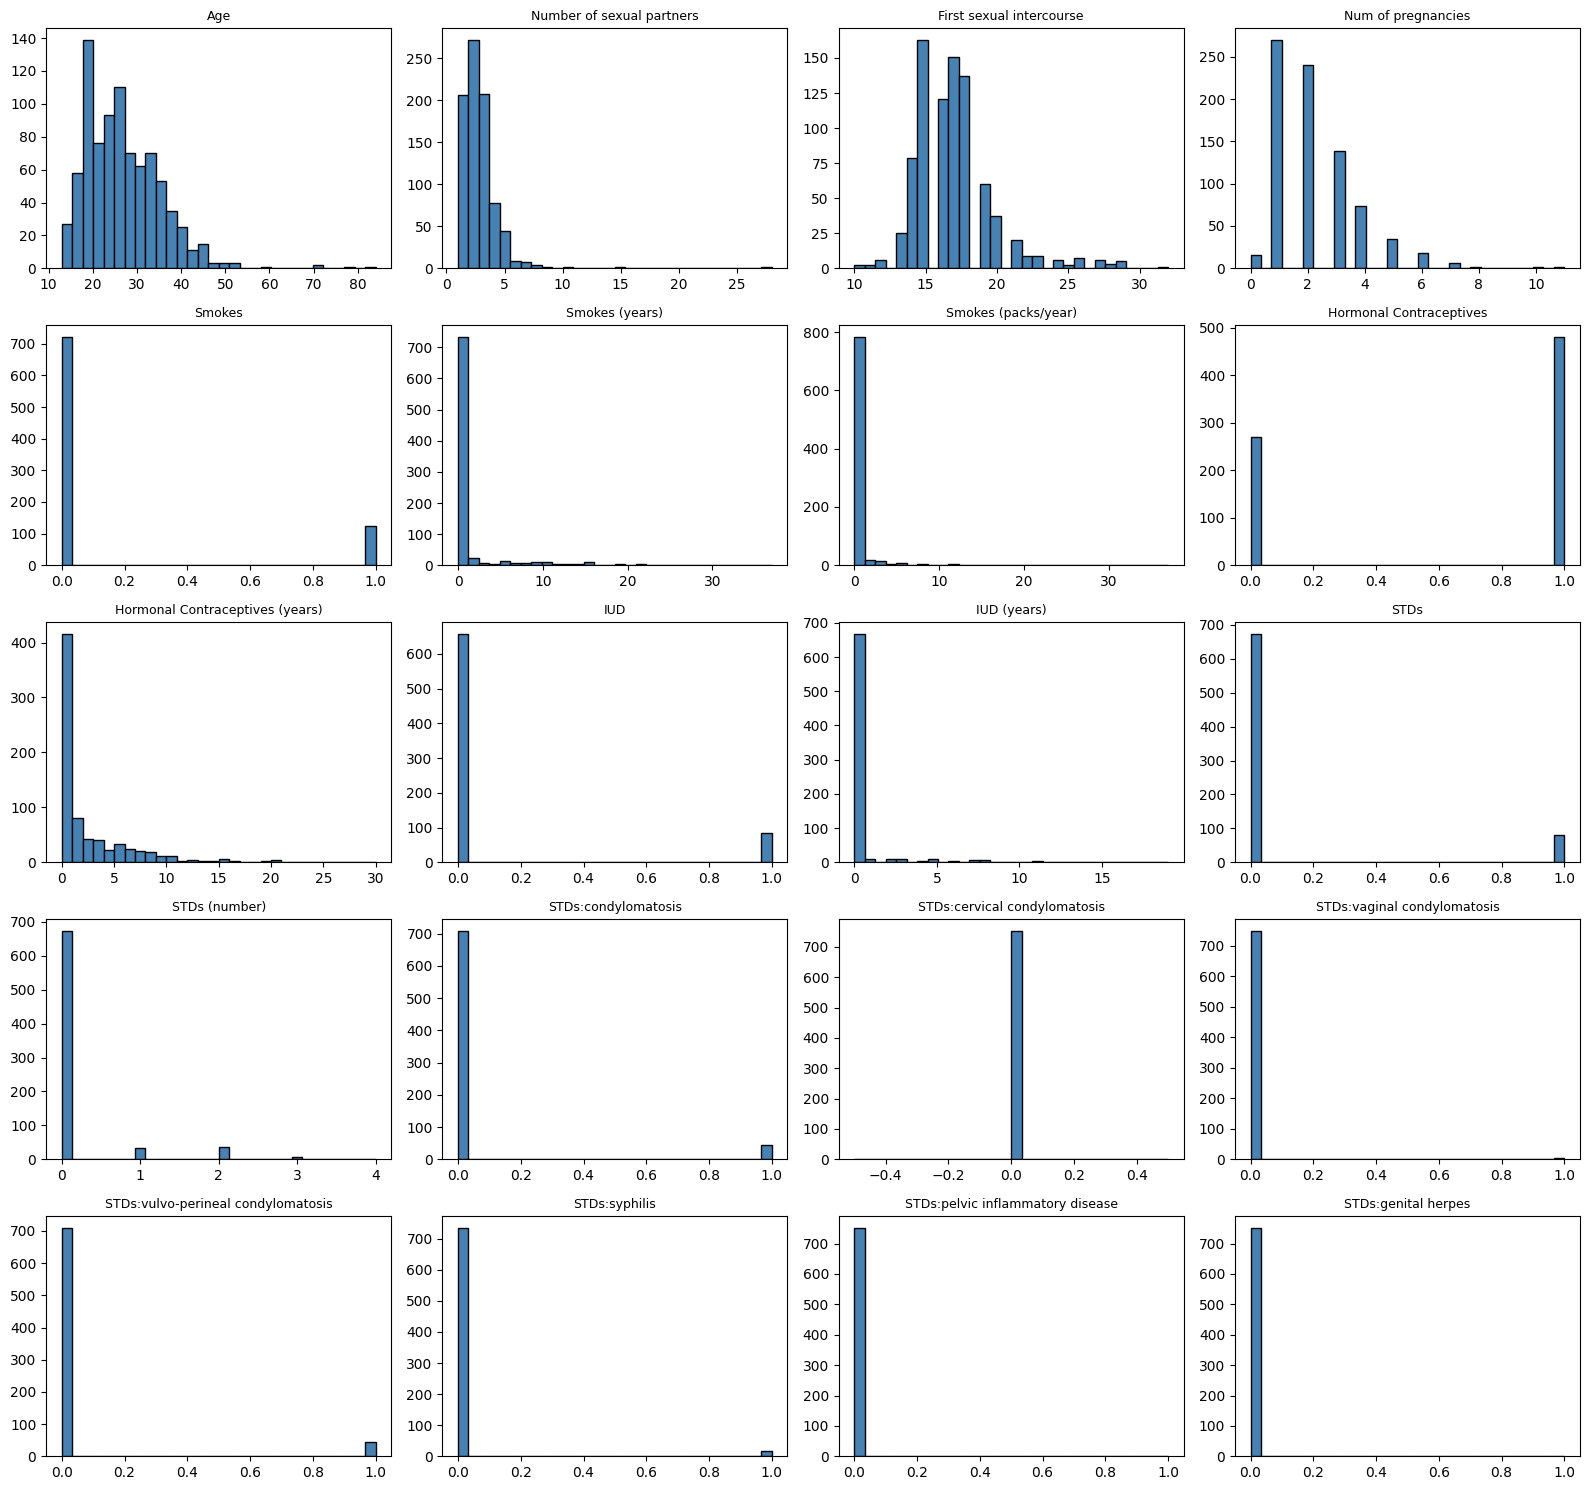

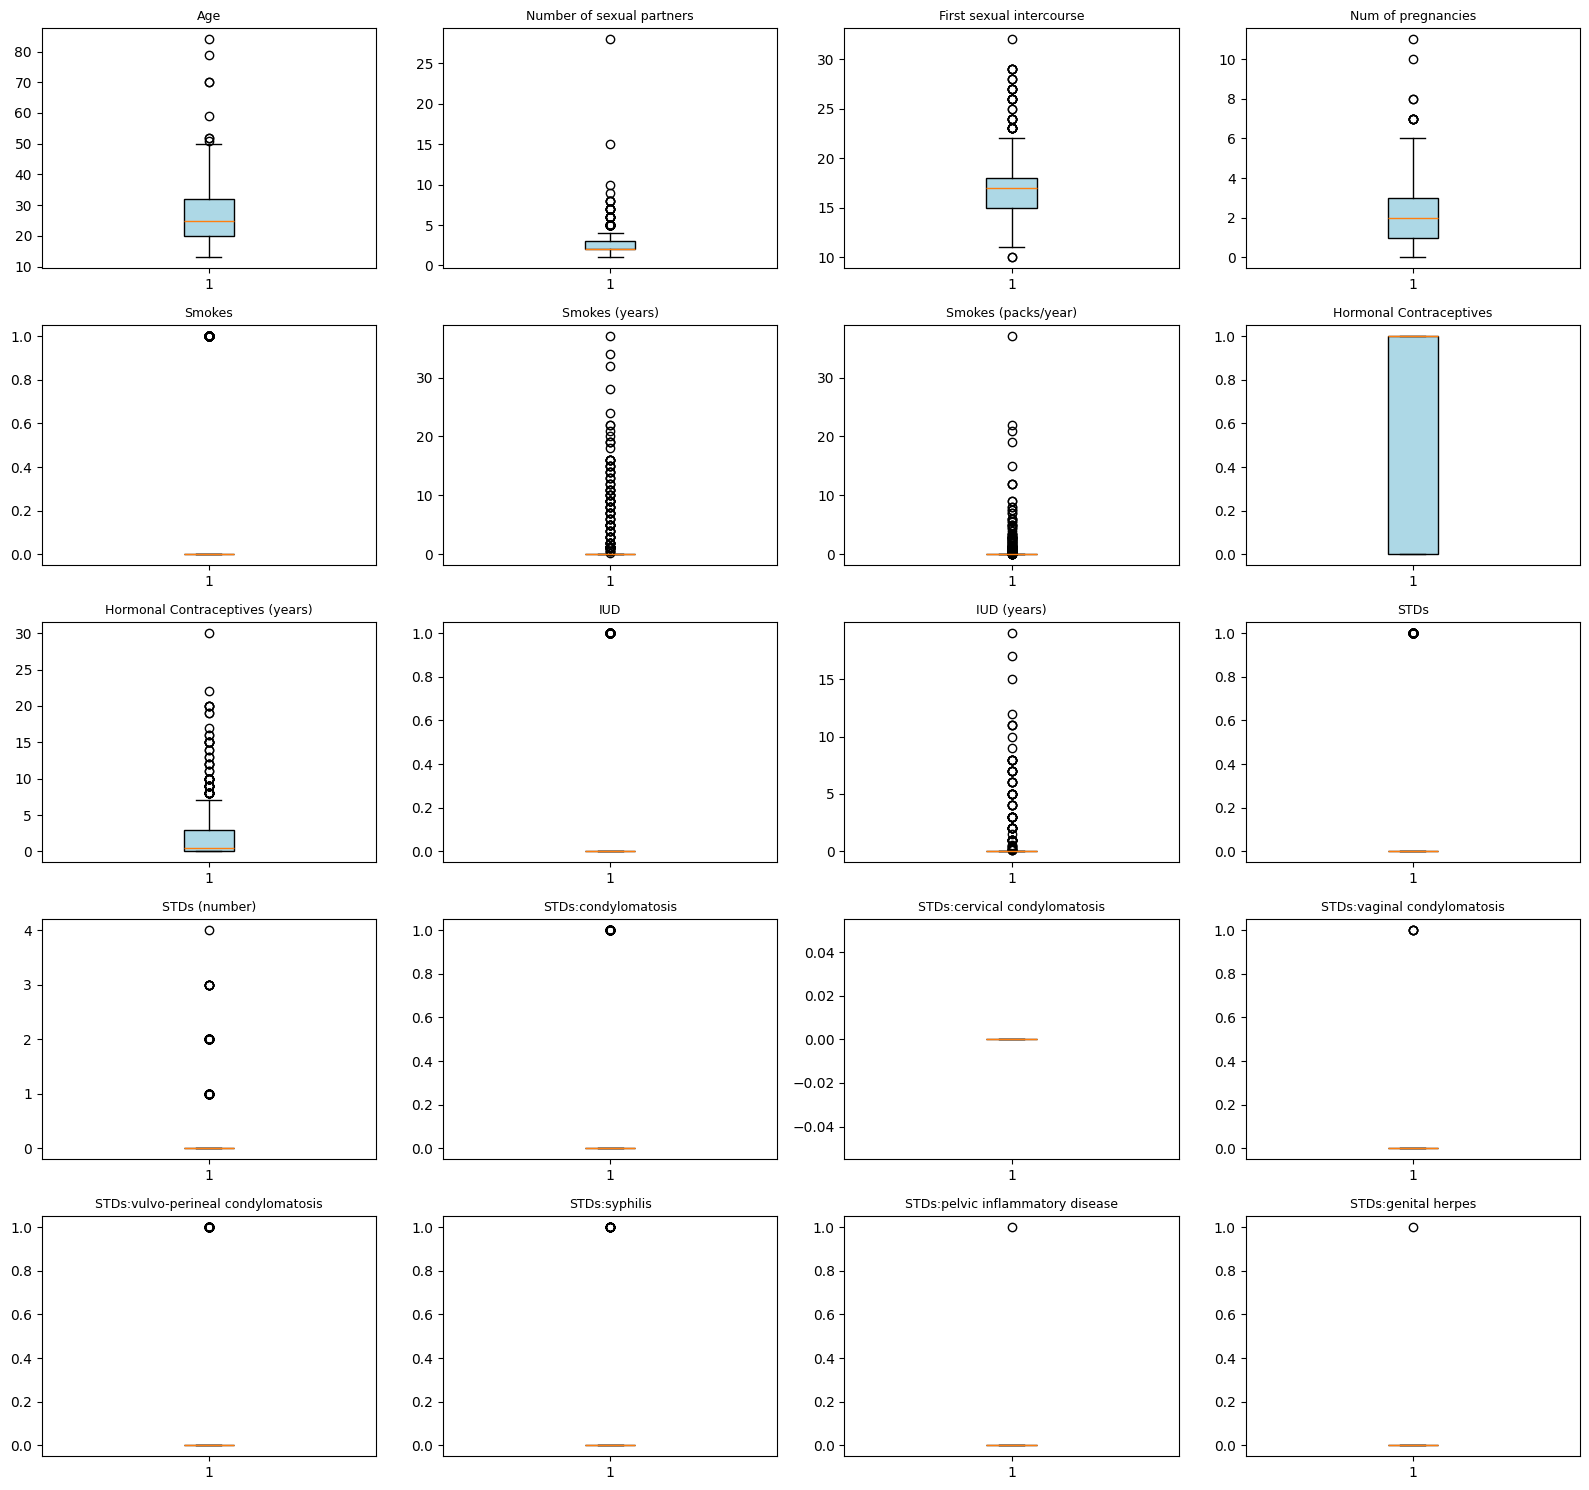

In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Evitar incluir el target en la lista de predictoras
num_cols_wo_target = [c for c in num_cols if c != TARGET]

print("Numéricas (sin target):", len(num_cols_wo_target))
display(df[num_cols_wo_target].describe().T)

# Número máximo de histogramas
max_plots = 20

# Columnas a graficar (las primeras 20 como ya tenías)
cols_to_plot = num_cols_wo_target[:max_plots]

# Configurar tamaño de la cuadrícula
cols_per_row = 4   # Cambia a 5 si querés más compacto
rows = math.ceil(len(cols_to_plot) / cols_per_row)

# Crear figura global
plt.figure(figsize=(cols_per_row * 4, rows * 3))

for i, c in enumerate(cols_to_plot):
    plt.subplot(rows, cols_per_row, i + 1)
    s = df[c].dropna()
    plt.hist(s, bins=30, color="steelblue", edgecolor="black")
    plt.title(c, fontsize=9)
    plt.tight_layout()

plt.show()

# Número máximo de boxplots
max_plots = 20
cols_to_plot = num_cols_wo_target[:max_plots]

# Configuración de la grilla
cols_per_row = 4
rows = math.ceil(len(cols_to_plot) / cols_per_row)

plt.figure(figsize=(cols_per_row * 4, rows * 3))

for i, c in enumerate(cols_to_plot):
    plt.subplot(rows, cols_per_row, i + 1)
    s = df[c].dropna()
    plt.boxplot(s, vert=True, patch_artist=True,
                boxprops=dict(facecolor="lightblue"))
    plt.title(c, fontsize=9)
    plt.tight_layout()

plt.show()


## 6) EDA/Relaciones y correlación

- Matriz de correlación (numéricas)
- Asociación con el target (correlación punto-biserial / Pearson con y binaria)


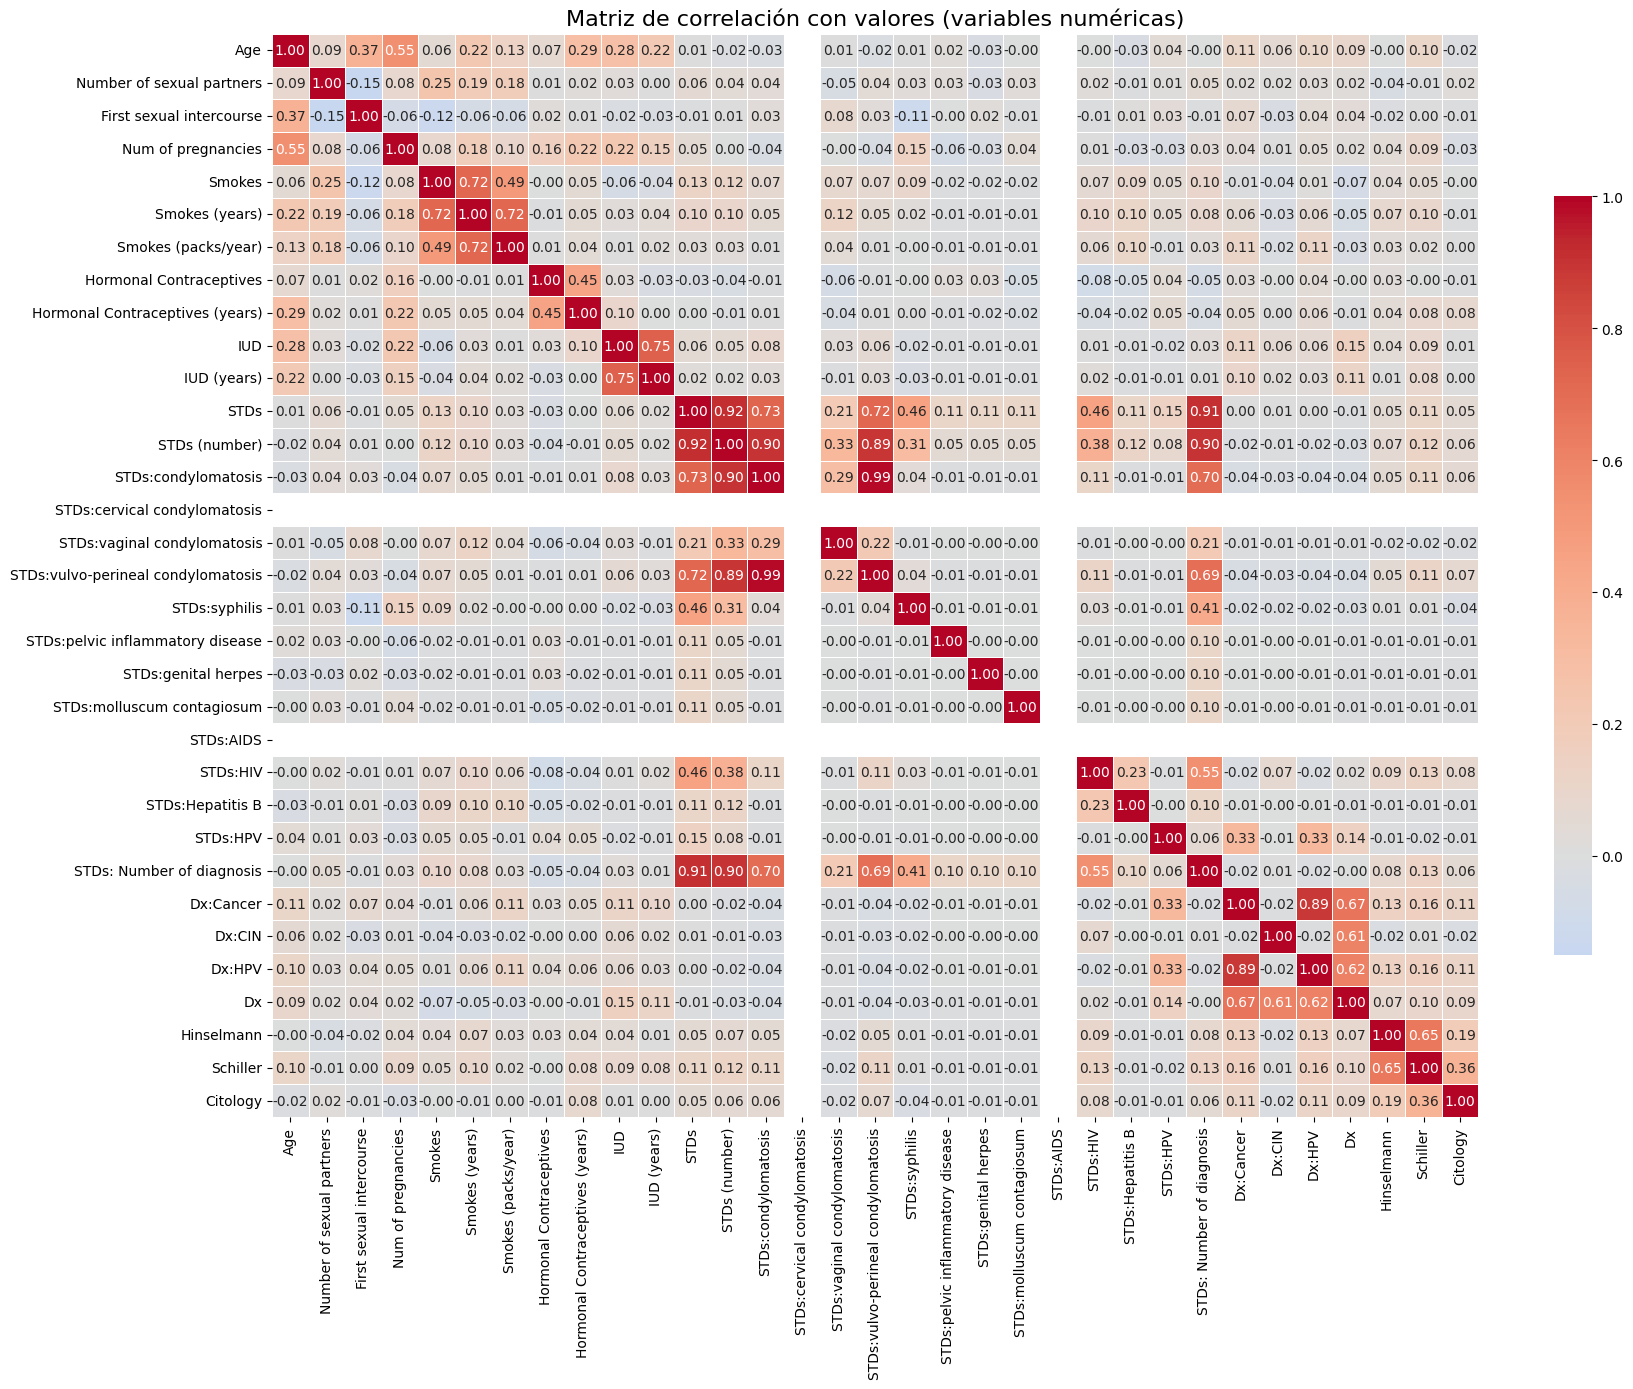

c:\Users\guiss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\guiss\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\guiss\AppData\Local\Temp\ipykernel_29608\2324460966.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


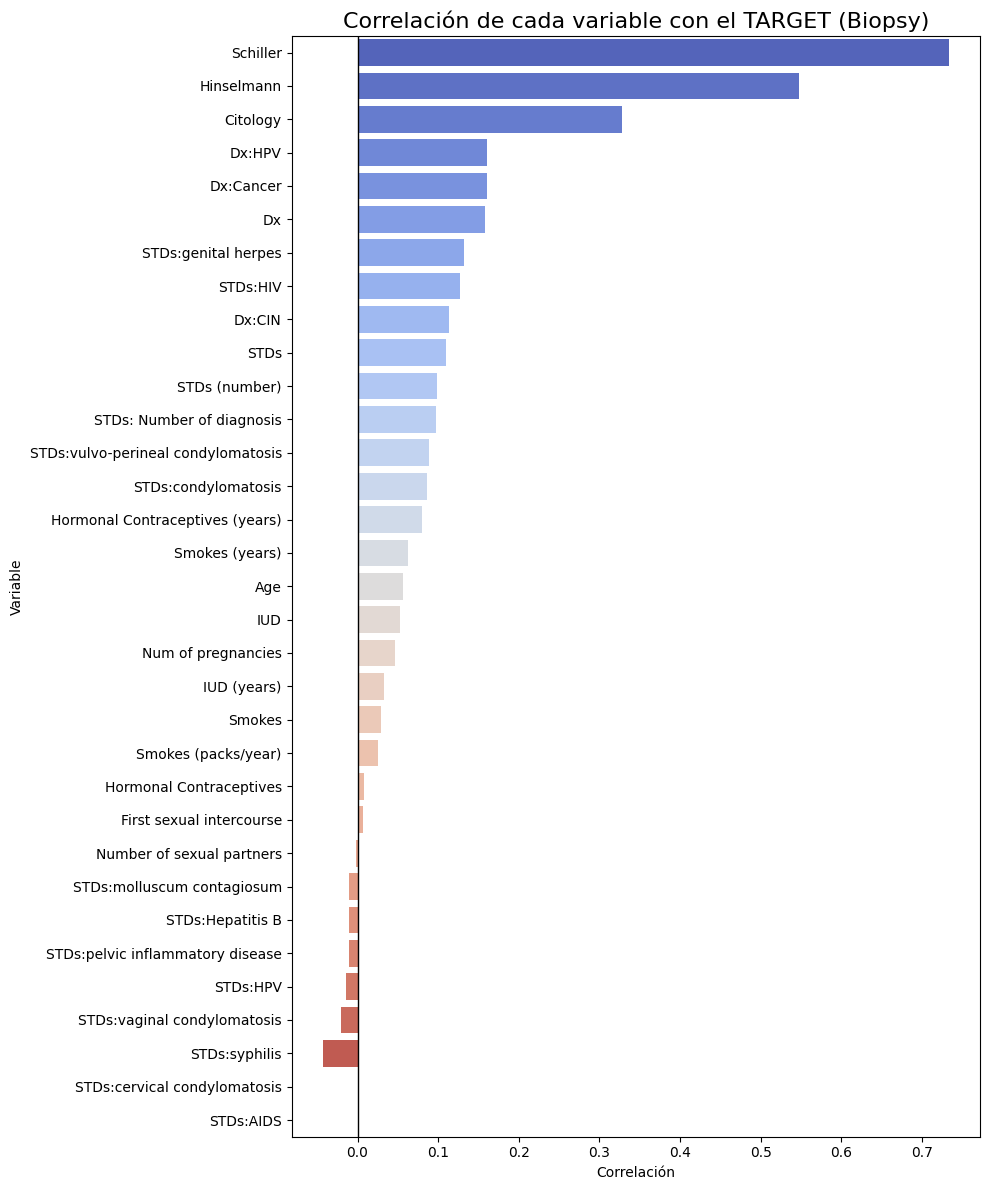

,corr_with_target
Schiller,0.733204
Hinselmann,0.547417
Citology,0.327466
Dx:HPV,0.160905
Dx:Cancer,0.160905
Dx,0.157607
STDs:genital herpes,0.132526
STDs:HIV,0.126880
Dx:CIN,0.113172
STDs,0.109099


In [8]:
#Correlaciones
corr = df[num_cols_wo_target].corr()
plt.figure(figsize=(18, 14))
cmap = sns.diverging_palette(240, 10, as_cmap=True).reversed() 
sns.heatmap(
    corr,
    annot=True,           # muestra los valores de correlación
    fmt=".2f",            # formato de números
    cmap="coolwarm",      # colormap similar al de tu segunda imagen
    center=0,             # 0 al centro
    linewidths=0.5,       # líneas finas entre celdas
    cbar_kws={'shrink': 0.7}  # barra más pequeña
)

plt.title("Matriz de correlación con valores (variables numéricas)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calcular correlación del target con las variables numéricas
y = df[TARGET].astype(float)

corr_target = df[num_cols_wo_target].corrwith(y)

# Convertir a dataframe ordenado
corr_target = corr_target.sort_values(ascending=False).to_frame("corr_with_target")
corr_target.head(20)

plt.figure(figsize=(10, 12))

sns.barplot(
    data=corr_target,
    x="corr_with_target",
    y=corr_target.index,
    palette="coolwarm"
)

plt.title("Correlación de cada variable con el TARGET (Biopsy)", fontsize=16)
plt.xlabel("Correlación")
plt.ylabel("Variable")
plt.axvline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()


if set(y.dropna().unique()).issubset({0,1}):
    y_num = y.astype(float)
    assoc = {}
    for c in num_cols_wo_target:
        s = df[c]
        tmp = pd.concat([s, y_num], axis=1).dropna()
        if tmp.shape[0] >= 10 and tmp[c].nunique() > 1:
            assoc[c] = np.corrcoef(tmp[c].astype(float), tmp[TARGET])[0,1]
    assoc = pd.Series(assoc).sort_values(key=lambda x: x.abs(), ascending=False)
    display(assoc.to_frame("corr_with_target").head(20))


## 7) Outliers (univariados) y estrategias de tratamiento

Usaremos diagnóstico univariado para identificar valores extremos:
- **Z-score robusto** vía MAD (Median Absolute Deviation) *(no asume normalidad y es menos sensible a valores extremos clínicamente reales)*

Las estrategias de tratamiento se evalúan posteriormente durante el modelado:
1) **Sin eliminar** (solo imputación/escala).
2) **Filtrado en entrenamiento** con **IsolationForest** (multivariado) para robustez.


In [9]:
def outliers_zscore(series, thresh=3.5):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.nunique() < 5:
        return pd.Index([])

    median = np.median(s)
    mad = np.median(np.abs(s - median))

    if mad == 0 or np.isnan(mad):
        return pd.Index([])

    robust_z = 0.6745 * (s - median) / mad
    return s.index[np.abs(robust_z) > thresh]

outlier_report = []
for c in num_cols_wo_target:
    if df[c].dropna().nunique() < 5:
        continue
    idx_z = outliers_zscore(df[c], thresh=3.5)
    outlier_report.append((c, len(idx_z)))

outlier_report = pd.DataFrame(outlier_report, columns=["feature", "n_outliers_zscore"])
display(outlier_report.sort_values("n_outliers_zscore", ascending=False).head(20))



,feature,n_outliers_zscore
6,Hormonal Contraceptives (years),172
2,First sexual intercourse,9
1,Number of sexual partners,8
0,Age,5
3,Num of pregnancies,4
4,Smokes (years),0
5,Smokes (packs/year),0
7,IUD (years),0
8,STDs (number),0


# Interpretacion del diagnostico:
El detector basado en MAD identifica un número mayor de valores extremos en variables como 
**“Hormonal Contraceptives (years)”**, lo cual refleja una distribución altamente asimétrica y **no errores de medición**. En un contexto clínico, estos valores extremos pueden representar exposiciones prolongadas relevantes, por lo que se consideran informativos y no se eliminan de forma directa.

### Validación del supuesto de normalidad multivariada
Se evaluó la normalidad multivariada para confirmar que el conjunto de datos no cumple supuestos gaussianos, lo cual refuerza la elección de modelos no paramétricos y robustos como Random Forest, SVM y Gradient Boosting, en lugar de modelos que dependen estrictamente de supuestos de normalidad.


In [10]:
import pingouin as pg

# Seleccionar variables numéricas (excluyendo el target)
X_numeric = df[num_cols_wo_target].dropna()

# Test de normalidad multivariada de Mardia
mardia = pg.multivariate_normality(X_numeric, alpha=0.05)
mardia


HZResults(hz=2672, pval=0.0, normal=False)

## 8) Modelado multivariado (clasificación)

### Modelos incluidos
- **Baseline**: DummyClassifier
- **Logistic Regression** (L2) — modelo lineal probabilístico, robusto y explicable
- **SVM RBF** — no paramétrico, funciona bien en fronteras no lineales
- **Random Forest** — robusto a no linealidad y outliers
- **Gradient Boosting** — potente en tabulares

### Preprocesamiento
- imputación (mediana / moda),
- escalado,
- codificación OneHot si existen categóricas.

Se usa **validación cruzada estratificada** y métricas:
- **ROC-AUC** (si binario),
- **F1**,
- **Accuracy**,
- **Recall**,
- **Precision**.

> Importante: para evitar leakage, todo va dentro de Pipelines.


In [11]:
# Features / target
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Mantener solo filas con target no nulo
mask = y.notna()
X = X.loc[mask].copy()
y = y.loc[mask].copy()

# Asegurar que sea numérico
y = pd.to_numeric(y, errors="coerce")
uniq = sorted(pd.Series(y.dropna().unique()).tolist())
print("Clases únicas target:", uniq)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y if len(uniq) <= 2 else None
)


# Columnas numéricas/categóricas
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())#Se escanlan 
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features)
    ],
    remainder="drop"
)

models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "LogReg_L2": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample"),
    "GradBoost": GradientBoostingClassifier(random_state=42),
}

scoring = {
    "acc": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",    
    "roc_auc": "roc_auc"
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
pipes = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    pipes[name] = pipe
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, error_score="raise")
    row = {"model": name}
    for k, v in scores.items():
        if k.startswith("test_"):
            row[k.replace("test_", "")] = float(np.mean(v))
            row[k.replace("test_", "")+"_std"] = float(np.std(v))
    results.append(row)

results_df = pd.DataFrame(results).sort_values(by=["recall", "precision","roc_auc"], ascending=False)
display(results_df)


Clases únicas target: [0, 1]


,model,acc,acc_std,f1,f1_std,recall,recall_std,precision,precision_std,roc_auc,roc_auc_std
1,LogReg_L2,0.941712,0.009067,0.649177,0.033200,0.841667,0.112354,0.534853,0.035269,0.955304,0.028481
2,SVM_RBF,0.947562,0.020175,0.606846,0.175344,0.663889,0.230472,0.566010,0.138219,0.959199,0.004781
4,GradBoost,0.957749,0.011563,0.657488,0.087790,0.633333,0.096864,0.694408,0.110641,0.972624,0.014144
3,RandomForest,0.950428,0.005531,0.504321,0.090231,0.405556,0.104822,0.700476,0.077903,0.943288,0.038750
0,Dummy,0.935862,0.002878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000


# Interpretacion
**Modelo con mayor sentido clínico:** **Logistic Regression (L2)**

- Presenta el **mayor recall (~0.84)**, detectando la mayoría de los casos positivos.
- Muestra una **precision moderada**, aceptable en un contexto de *screening*.
- Mantiene un **ROC-AUC sólido** y **baja variabilidad** entre folds.
- Es un modelo **explicable**, aspecto clave en aplicaciones de salud.

> En detección temprana de cáncer cervical, **es preferible un falso positivo a un falso negativo**.

**Modelos no seleccionados:**
- **Gradient Boosting:** alta precision, pero **recall insuficiente (~0.63)**, con pérdida relevante de casos.
- **Random Forest:** **recall muy bajo (~0.40)**, no adecuado para *screening*.
- **SVM RBF:** recall medio y mayor variabilidad, sin mejoras frente a la regresión logística.

**Decisión:**  
El criterio de selección basado en **recall → precision → ROC-AUC** es clínicamente adecuado.  
El modelo seleccionado para la siguiente etapa es **Logistic Regression (L2)**.

## 9) Entrenamiento final del mejor modelo + evaluación en test

- Con base en la validación cruzada del Paso 8, se selecciona como modelo final la  
  **Regresión Logística con regularización L2**, al presentar la **mayor sensibilidad (recall)**,
  criterio prioritario en la **detección temprana de cáncer cervical**.

- El modelo se entrena con el conjunto de entrenamiento completo y se evalúa en un
  **conjunto de prueba independiente** para validar su capacidad de generalización.

- La evaluació en test incluye:
  - **Matriz de confusión**
  - **Reporte de clasificación**, con énfasis en *recall* y *precision*.
  - **Curva ROC y AUC** como medida global de discriminación.
  
- Este paso confirma que el desempeño observado en validación cruzada se mantiene fuera de muestra,
  antes de evaluar variantes experimentales como el **filtrado de outliers**.


Mejor modelo (CV): LogReg_L2
              precision    recall  f1-score   support

           0     0.9873    0.9689    0.9781       161
           1     0.6429    0.8182    0.7200        11

    accuracy                         0.9593       172
   macro avg     0.8151    0.8936    0.8490       172
weighted avg     0.9653    0.9593    0.9616       172



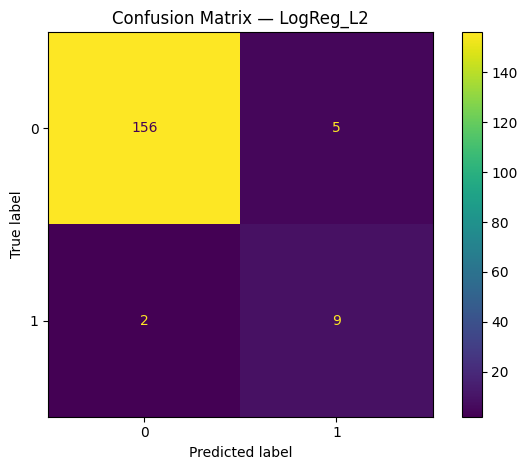

ROC-AUC (test): 0.9034443817052513


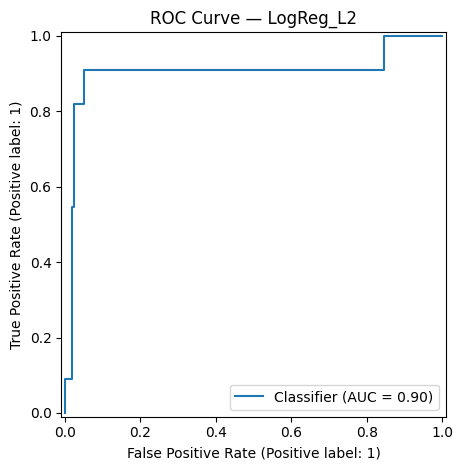

In [12]:

best_name = results_df.iloc[0]["model"]
best_pipe = pipes[best_name]
print("Mejor modelo (CV):", best_name)

best_pipe.fit(X_train, y_train)

# Predicciones
y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout()
plt.show()

# ROC-AUC (si binario)
if set(pd.Series(y_test.dropna().unique()).tolist()).issubset({0,1}):
    y_proba = best_pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC (test):", auc)
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {best_name}")
    plt.tight_layout()
    plt.show()


## 10) Variante: filtrado de outliers multivariados (IsolationForest) en entrenamiento

En vez de eliminar basado en una sola variable, usamos un detector **multivariado** sobre *X_train* preprocesado:

- Ajustamos `IsolationForest` sobre `X_train` (transformado),
- filtramos observaciones anómalas,
- Re-entrenamos el mejor modelo y comparamos métricas en test.
- - Comparación del desempeño en test frente al modelo sin filtrado mediante métricas de clasificación y ROC-AUC.

> Esto es útil si se observan valores extremos que distorsionan modelos lineales o discriminantes.


== Evaluación base (sin filtrado) ==
              precision    recall  f1-score   support

           0     0.9873    0.9689    0.9781       161
           1     0.6429    0.8182    0.7200        11

    accuracy                         0.9593       172
   macro avg     0.8151    0.8936    0.8490       172
weighted avg     0.9653    0.9593    0.9616       172

Recall base: 0.8181818181818182
Precision base: 0.6428571428571429
Entrenamiento original: 686  | inliers: 665  | outliers: 21
== +++++++++++++++++++++++++++++++++++++++++++++++++++++ ==
== Evaluación en test (modelo re-entrenado con filtrado) ==
              precision    recall  f1-score   support

           0     0.9873    0.9689    0.9781       161
           1     0.6429    0.8182    0.7200        11

    accuracy                         0.9593       172
   macro avg     0.8151    0.8936    0.8490       172
weighted avg     0.9653    0.9593    0.9616       172

Recall filtrado: 0.8181818181818182
Precision filtrado: 0.6428

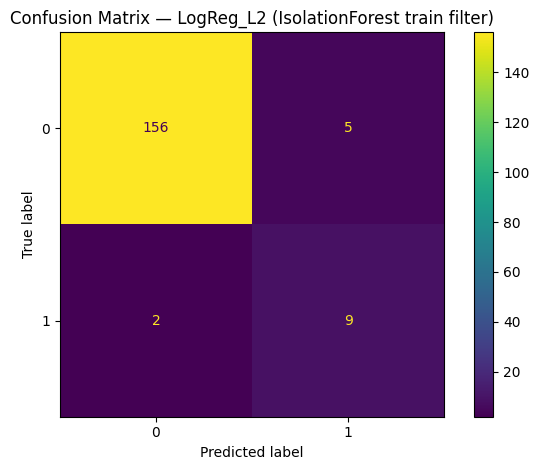

ROC-AUC (test) con filtrado: 0.9051383399209485


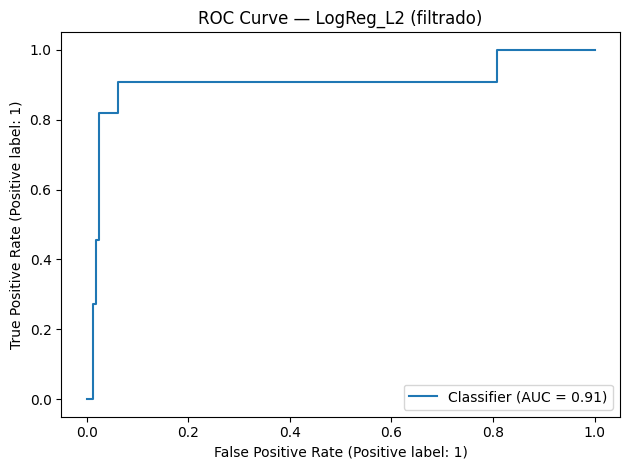

In [14]:

from sklearn.ensemble import IsolationForest
from sklearn.base import clone
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, recall_score, precision_score


# 0) Comparación base (sin filtrado)
print("== Evaluación base (sin filtrado) ==")
print(classification_report(y_test, y_pred, digits=4))
print("Recall base:", recall_score(y_test, y_pred))
print("Precision base:", precision_score(y_test, y_pred))


# 1) Transform X_train con el "prep" del mejor pipeline (sin entrenar modelo)
prep_only = preprocess
Xtr_p = prep_only.fit_transform(X_train)
Xte_p = prep_only.transform(X_test)

iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(Xtr_p)
inlier_mask = iso.predict(Xtr_p) == 1

print("Entrenamiento original:", X_train.shape[0], " | inliers:", int(inlier_mask.sum()), " | outliers:", int((~inlier_mask).sum()))

# Re-entrenar SOLO el modelo (mismo algoritmo del mejor pipeline) sobre inliers
best_model = models[best_name]
best_model.fit(Xtr_p[inlier_mask], y_train.iloc[inlier_mask])

y_pred2 = best_model.predict(Xte_p)
print("== +++++++++++++++++++++++++++++++++++++++++++++++++++++ ==")
print("== Evaluación en test (modelo re-entrenado con filtrado) ==")
print(classification_report(y_test, y_pred2, digits=4))
print("Recall filtrado:", recall_score(y_test, y_pred2))
print("Precision filtrado:", precision_score(y_test, y_pred2))

cm2 = confusion_matrix(y_test, y_pred2)
ConfusionMatrixDisplay(confusion_matrix=cm2).plot()
plt.title(f"Confusion Matrix — {best_name} (IsolationForest train filter)")
plt.tight_layout()
plt.show()

if set(pd.Series(y_test.dropna().unique()).tolist()).issubset({0,1}) and hasattr(best_model, "predict_proba"):
    y_proba2 = best_model.predict_proba(Xte_p)[:,1]
    auc2 = roc_auc_score(y_test, y_proba2)
    print("ROC-AUC (test) con filtrado:", auc2)
    
    RocCurveDisplay.from_predictions(y_test, y_proba2)
    plt.title(f"ROC Curve — {best_name} (filtrado)")
    plt.tight_layout()
    plt.show()

### Conclusión del filtrado multivariado

El filtrado de outliers mediante IsolationForest no produjo cambios en el desempeño del modelo en el
conjunto de prueba. Las métricas clave (recall y precision), la matriz de confusión y el ROC-AUC
permanecieron inalterados respecto al modelo sin filtrado.

Esto indica que los valores extremos presentes en el conjunto de datos no distorsionan el desempeño
del modelo y pueden corresponder a variabilidad clínica real. En consecuencia, se decide **no aplicar
filtrado de outliers** y mantener el modelo base para la detección temprana de cáncer cervical.

## 11) Justificación metodológica y conclusión

Dado que el problema corresponde a detección temprana de cáncer cervical, se priorizó la sensibilidad
(*recall*) como métrica principal para minimizar falsos negativos. La precisión fue utilizada como
métrica secundaria para controlar el número de falsos positivos, manteniendo un balance clínicamente
aceptable.

Bajo este criterio, la Regresión Logística con regularización L2 fue seleccionada como modelo final.
Las variantes experimentales evaluadas, como el filtrado multivariado de outliers mediante
IsolationForest, no mostraron mejoras en sensibilidad, por lo que se decidió mantener el modelo base
sin filtrado.